This notebook was created for the study of a galaxy Seyfert Type II.

In [1]:
%run __init__.py

Defining our source

In [2]:
# Import the class
from __init__ import BHPhysics

# Initialize the BHPhysics class
bh_physics = BHPhysics(Gamma=1/np.sqrt(2), r_x=6, l=10, l_x=5, q=(1 - (3 / 6)**(1/2))**(1/4), mdot=0.7, m=2e7)

# Calculate parameters
wdot_B = bh_physics.mag_rec_power()
B_c = bh_physics.coronal_mag_field()
n_c = bh_physics.coronal_density()
T_c = bh_physics.coronal_temperature()
delta_RX = bh_physics.width_current_sheet()

# Print results
print(f'\nReconnection Power:\n wdot_B = {wdot_B:.4E} erg s-1')
print(f'\nCoronal Magnetic Field:\n B_c = {B_c:.4E} G')
print(f'\nCoronal Particle Number Density:\n n_c = {n_c:.4E} cm-3')
print(f'\nCoronal Temperature:\n T_c = {T_c:.4E} K')
print(f'\nWidth of the current sheet:\n delta_RX = {delta_RX:.4E} cm')


Reconnection Power:
 wdot_B = 5.1226E+42 erg s-1

Coronal Magnetic Field:
 B_c = 1.9843E+04 G

Coronal Particle Number Density:
 n_c = 5.1761E+10 cm-3

Coronal Temperature:
 T_c = 3.1016E+09 K

Width of the current sheet:
 delta_RX = 4.2860E+10 cm


In [3]:
# c = (const.c).to('cm s-1')
# m_e = (const.m_e).to('g')
# m_p = (const.m_p).to('g')
# sigma_T = (const.sigma_T).to('cm2')
# e = (const.e).value / (3.33564e-10) * u.statcoulomb

# alpha_f = 1/137 # fine structure constant [dim.]
# r_0 = 2.8179e-13 * u.cm # electron classical radius [cm]

In [4]:
# def mag_rec_power(Gamma, r_X, l, l_X, q, mdot, m):
#     ''' Magnetic recconection power released by turbulent fast reconnection in the surrounds of the BH.
#     Eq. (15) of Kadowaki, de Gouveia Dal Pino & Singh 2015 (KGS15).'''
#     # [erg s-1]
    
#     return 1.66e35 * Gamma**(-1/2) * r_X**(-5/8) * l**(-1/4) * l_X * q**(-2) * mdot**(3/4) * m

# def coronal_mag_field(r_x, mdot, m):
#     '''Inner disk magnetic field intensity.
#     Eq.(2) of KGS15.'''
#     # [G]
    
#     return 9.96e8 * r_x**(-5/4) * mdot**(1/2) * m**(-1/2)

# def coronal_density(Gamma, r_x, l,  q, mdot, m):
#     '''Eq.(7) of KGS15.'''
#     # [cm-3]
    
#     return 8.02e18 * Gamma**(1/2) * r_x**(-3/8) * l**(-3/4) * q**(-2) * mdot**(1/4) * m**(-1)

# def coronal_temperature(Gamma, r_x, l, q, mdot):
#     '''Eq.(6) of KGS15.'''
#     # [K]
    
#     return 2.73e9 * Gamma**(1/4) * r_x**(-3/16) * l**(1/8) * q**(-1) * mdot**(1/8)

# def width_current_sheet(Gamma, r_x, l, l_x, q, mdot, m):
#     '''Eq.(14) from ERRATUM of KGS15.'''
#     # [cm]
    
#     return 11.6 * Gamma**(-5/4) * r_x**(31/16) * l**(-5/8) * l_x * q**(-3) * mdot**(-5/8) * m

In [5]:
# wdot_B = mag_rec_power(Gamma, r_x, l, l_x, q, mdot, m) # erg s-1
# B_c = coronal_mag_field(r_x, mdot, m) # G
# n_c = coronal_density(Gamma, r_x, l,  q, mdot, m) # cm-3
# T_c = coronal_temperature(Gamma, r_x, l, q, mdot) # K
# delta_RX = width_current_sheet(Gamma, r_x, l, l_x, q, mdot, m) # cm

In [6]:
# print(f'\nReconnection Power:\n wdot_B = {wdot_B:.4E} erg s-1')
# print(f'\nCoronal Magnetic Field:\n B_c = {B_c:.4E} G')
# print(f'\nCoronal Particle Number Density:\n n_c = {n_c:.4E} cm-3')
# print(f'\nCoronal Temperature:\n T_c = {T_c:.4E} K')
# print(f'\nWidth of the current sheet:\n delta_RX = {delta_RX:.4E} cm')

In [7]:
erg = 1.602177e-12 # [1 eV = 1.6022e-12 erg]

Ep = np.linspace(1e9, 1e16)*erg # Energy range [erg]

rho = n_c * m_p # [g cm-3] fluid density

In [8]:
E_norm = Ep / (m_p*c**2)

In [9]:
# E_norm

In [10]:
va0 = B_c / np.sqrt(4 * np.pi * rho)

va = va0 * Gamma

va/c

0.44871560804816396

In [11]:
r_c = 10 * R_s  # [cm] coronal size
L_x = 7 * 10**43 # [erg s-1]
epsilon_0 = 7e3 * erg # [erg] 7 keV = 7e3 * erg to eV compton hump energy

U_x = L_x / (4 * np.pi * c * r_c**2)

In [12]:
n_x = U_x * ( epsilon_0**(-2) * (20e3 * erg - 1e3 * erg) + ( -(200e3*erg)**(-1) + (20e3*erg)**(-1) ) )

In [13]:
print(f'\nPhoton field Energy Density for X-rays = {n_x:.5E} cm-3')


Photon field Energy Density for X-rays = 1.43205E+13 cm-3


In [14]:
def timeacc_fermi(E):
    '''Eq.(2.37) of Medina-Torrejon Thesis'''
    alpha = 0.1
    s = 1/alpha
    E0 = 10**(4)
    t0 = 700
    ## hours
    # return s**(-1) * (E0/E)**(-1/s) * t0
    return (E0/E)**(-1/s) * t0


def timeacc_drift(E, B, va):
    '''Eq.(7) of Del Valle, de Gouveia Dal Pino & Kowal 2016 e de Gouveia Dal Pino & Kowal 2015'''
    v_rec = 0.05 * va
    
    return E / (e*B*v_rec)

Hadrons

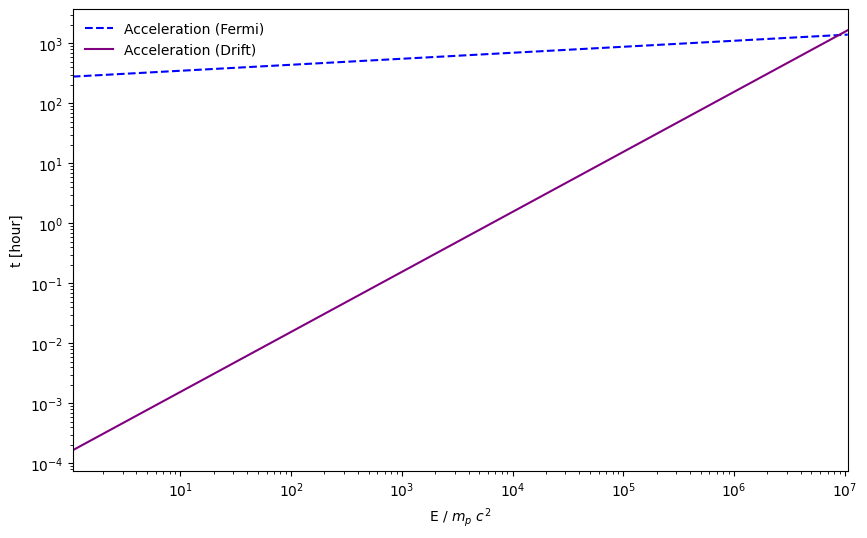

In [15]:
## erg

plt.figure(figsize=(10, 6))

plt.loglog(E_norm,timeacc_fermi(E_norm),'--',label='Acceleration (Fermi)',color='blue')
plt.loglog(E_norm,timeacc_drift(E_norm, B_c, va),label='Acceleration (Drift)',color='purple')

plt.xlim((E_norm.min(),E_norm.max()))
plt.legend(frameon=False)
plt.xlabel('E / $m_p$ $c^2$')
plt.ylabel('t [hour]')
# plt.ylim((1e-4,1e4))
# plt.xticks([1e-2,1e-1,1e0,1e1,1e2,1e3],labels=['-2','-1','0','1','2','3'])
# plt.savefig('plots/cooling_hadrons_erg.png',dpi=300)

plt.show()

In [16]:
# ## eV

# plt.figure(figsize=(10, 6))

# plt.loglog(E_norm/erg,timeacc_fermi(E_norm),'--',label='Acceleration (Fermi)',color='blue')
# plt.loglog(E_norm/erg,timeacc_drift(E_norm, B_c, va),label='Acceleration (Drift)',color='purple')

# plt.xlim((E_norm.min()/erg,E_norm.max()/erg))
# plt.legend(frameon=False)
# plt.xlabel(f'E / $m_p$ $c^2$')
# plt.ylabel(f't [hour]')
# # plt.ylim((1e-11,1e9))
# # plt.xticks([1e9,1e10,1e11,1e12,1e13,1e14,1e15],labels=['9','10','11','12','13','14','15'])

# # plt.savefig('plots/cooling_hadrons_eV.png',dpi=300)

# plt.show()